# **Least squares regression**

    Notebook version: 1.3 (Sep 14, 2017)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - UTAD version
             v.1.2 - Minor corrections
             v.1.3 - Python 3 compatibility
    
    Pending changes: * 

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab

# For the student tests (only for python 2)
import sys
if sys.version_info.major==2:
    from test_helper import Test

This notebook covers the problem of fitting parametric regression models with a minimum least-squares criterion. The material presented here is based on the first lectures of this <a haref=http://mlg.eng.cam.ac.uk/teaching/4f13/1415/>Machine Learning course</a>. In particular, you can refer to the following presentation: <a href=http://mlg.eng.cam.ac.uk/teaching/4f13/1415/lect0102.pdf> Probabilistic Regression</a>.


## 1. A parametric approach to the regression problem

We have already presented the goal of regression. Given that we have access to a set of training points, $\{{\bf x}^{(l)}, s^{(l)}\}_{l=1}^L$, the goal is to learn a function $f({\bf x})$ that we can use to make good predictions for an arbitrary input vector.

The following plot illustrates a regression example for unidimensional input data. We have also generated three different regression curves corresponding to polynomia of degrees 1, 2, and 3 with random coefficients.

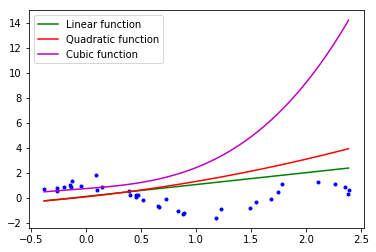

In [3]:
n_points = 35
n_grid = 200
frec = 3
std_n = 0.3

#Location of the training points
X_tr = (3 * np.random.random((n_points,1)) - 0.5)
#Labels are obtained from a sinusoidal function, and contaminated by noise
S_tr = np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
#Equally spaced points in the X-axis

X_grid = np.linspace(np.min(X_tr),np.max(X_tr),n_grid)
f1 = np.random.random((1,1)) + np.random.random((1,1))*X_grid
f2 = np.random.random((1,1)) + np.random.random((1,1))*X_grid + \
     np.random.random((1,1))*(X_grid**2)
f3 = np.random.random((1,1)) + np.random.random((1,1))*X_grid + \
     np.random.random((1,1))*(X_grid**2) + np.random.random((1,1))*(X_grid**3) 

plt.plot(X_tr,S_tr,'b.')
plt.plot(X_grid,f1.T,'g-',label='Linear function')
plt.plot(X_grid,f2.T,'r-',label='Quadratic function')
plt.plot(X_grid,f3.T,'m-',label='Cubic function')

plt.legend(loc='best')
plt.show()

### 1.1. Parametric model

Parametric regression models assume a parametric expression for the regression curve, adjusting the free parameters according to some criterion that measures the quality of the proposed model.

   - For a unidimensional case like the one in the previous figure, a convenient approach is to recur to polynomial expressions:

$${\hat s}(x) = f(x) = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M$$

   - For multidimensional regression, polynomial expressions can include cross-products of the variables. For instance, for a case with two input variables, the degree 2 polynomial would be given by
   
$${\hat s}({\bf x}) = f({\bf x}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2$$


   - A linear model for multidimensional regression can be expressed as
   
$${\hat s}({\bf x}) = f({\bf x}) = w_0 + {\bf w}^\top {\bf x}$$


When we postulate such models, the regression model is reduced to finding the most appropriate values of the parameters ${\bf w} = [w_i]$.

All the previous models have in common the fact that they are linear in the parameters, even though they can implement highly non-linear functions. All the derivations in this notebook are equally valid for other non-linear transformations of the input variables, as long as we keep linear-in-the-parameters models.

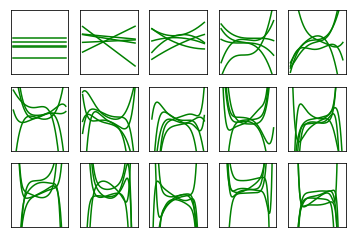

In [4]:
## Next, we represent some random polynomial functions for degrees between 0 and 14

max_degree = 15
n_points = 200

#Values of X to evaluate the function
X_grid = np.linspace(-1.5, 1.5,n_points)

for idx in range(max_degree):
    x1 = plt.subplot(3,5, idx+1)
    x1.get_xaxis().set_ticks([])
    x1.get_yaxis().set_ticks([])
    for kk in range(5):
        #Random generation of coefficients for the model
        we = np.random.randn(idx+1, 1)
        #Evaluate the polynomial with previous coefficients at X_grid values
        fout = np.polyval(we, X_grid)
        x1.plot(X_grid,fout,'g-')
        x1.set_ylim([-5,5])     

   - Should we choose a polynomial?
   
   - What degree should we use for the polynomial?
   
   - For a given degree, how do we choose the weights?
   
For now, we will find the single "best" polynomial. In a future session, we will see how we can design methods that take into account different polynomia simultaneously.

Next, we will explain how to choose optimal weights according to Least-Squares criterion.

## 2. Least squares regression

### 2.1. Problem definition

   - The goal is to learn a (possibly non-linear) regression model from a set of $L$ labeled points, $\{{\bf x}^{(l)},s{(l)}\}_{l=1}^L$.
   
   - We assume a parametric function of the form:
   
   $${\hat s}({\bf x}) = f({\bf x}) = w_0 z_0({\bf x}) + w_1 z_1({\bf x}) + \dots w_M z_M({\bf x})$$
   
   where $z_i({\bf x})$ are particular transformations of the input vector variables.

Some examples are:
   
   - If ${\bf z} = {\bf x}$, the model is just a linear combination of the input variables

   - If ${\bf z} = \left[\begin{array}{c}1\\{\bf x}\end{array}\right]$, we have again a linear combination with the inclusion of a constant term.


   - For unidimensional input $x$, ${\bf z} = [1, x, x^2, \dots,x^{M}]^\top$ would implement a polynomia of degree $M$.


   - Note that the variables of ${\bf z}$ could also be computed combining different variables of ${\bf x}$. E.g., if ${\bf x} = [x_1,x_2]^\top$, a degree-two polynomia would be implemented with 
      $${\bf z} = \left[\begin{array}{c}1\\x_1\\x_2\\x_1^2\\x_2^2\\x_1 x_2\end{array}\right]$$      

   - The above expression does not assume a polynomial model. For instance, we could consider ${\bf z} = [\log(x_1),\log(x_2)]$

Least squares (LS) regression finds the coefficients of the model with the aim of minimizing the square of the residuals. If we define ${\bf w} = [w_0,w_1,\dots,w_M]^\top$, the LS solution would be defined as
    
\begin{equation}{\bf w}_{LS} = \arg \min_{\bf w} \sum_{l=1}^L [e^{(l)}]^2 = \arg \min_{\bf w} \sum_{l=1}^L \left[s^{(l)} - {\hat s}^{(l)} \right]^2 \end{equation}

### 2.2. Vector Notation

In order to solve the LS problem it is convenient to define the following vectors and matrices:

   - We can group together all available target values to form the following vector
   
   $${\bf s} = \left[s^{(1)}, s^{(2)}, \dots, s^{(L)} \right]^\top$$



   - The estimation of the model for a single input vector ${\bf z}^{(l)}$ (which would be computed from ${\bf x}^{(l)}$), can be expressed as the following inner product
   
   $${\hat s}^{(l)} = {{\bf z}^{(l)}}^\top {\bf w}$$

   - If we now group all input vectors into a matrix ${\bf Z}$, so that each row of ${\bf Z}$ contains the transpose of the corresponding ${\bf z}^{(l)}$, we can express
   
   $$\hat{{\bf s}} = \left[{\hat s}^{1}, {\hat s}^{2}, \dots, {\hat s}^{(L)} \right]^\top = {\bf Z} {\bf w}, \;\;\;\; \text{with} \;\; {\bf Z} = \left[\begin{array}{cccc}z_0^{(1)}&z_1^{(1)}&\cdots&z_M^{(1)} \\ z_0^{(2)}&z_1^{(2)}&\cdots&z_M^{(2)} \\ \vdots & \vdots & \ddots & \vdots \\ z_0^{(L)}&z_1^{(L)}&\cdots&z_M^{(L)}\end{array}\right]$$

### 2.3. Least-squares solution

   - Using the previous notation, the cost minimized by the LS model can be expressed as
   
   $$C({\bf w}) = \sum_{l=1}^L \left[s^{(l)} - {\hat s}^{(l)} \right]^2 = \|{\bf s} - {\hat{\bf s}}\|^2 = \|{\bf s} - {\bf Z}{\bf w}\|^2$$
   

   - Since the above expression depends quadratically on ${\bf w}$ and is non-negative, we know that there is only one point where the derivative of $C({\bf w})$ becomes zero, and that point is necessarily a minimum of the cost
   
   $$\nabla_{\bf w} \|{\bf s} - {\bf Z}{\bf w}\|^2\Bigg|_{{\bf w} = {\bf w}_{LS}} = {\bf 0}$$

<b>Exercise:</b>
Solve the previous problem to show that
$${\bf w}_{LS} = \left( {\bf Z}^\top{\bf Z} \right)^{-1} {\bf Z}^\top{\bf s}$$

The next fragment of code adjusts polynomia of increasing order to randomly generated training data. To illustrate the composition of matrix ${\bf Z}$, we will avoid using functions $\mbox{np.polyfit}$ and $\mbox{np.polyval}$.

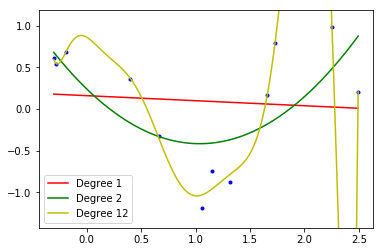

In [7]:
n_points = 12
n_grid = 200
frec = 3
std_n = 0.2
max_degree = 10

colors = 'brgcmyk'

#Location of the training points
X_tr = (3 * np.random.random((n_points,1)) - 0.5)
#Labels are obtained from a sinusoidal function, and contaminated by noise
S_tr = np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
#Equally spaced points in the X-axis
X_grid = np.linspace(np.min(X_tr),np.max(X_tr),n_grid)

#We start by building the Z matrix
Z = []
for el in X_tr.tolist():
    Z.append([el[0]**k for k in range(max_degree+1)])
Z = np.matrix(Z)

Z_grid = []
for el in X_grid.tolist():
    Z_grid.append([el**k for k in range(max_degree+1)])
Z_grid = np.matrix(Z_grid)

plt.plot(X_tr,S_tr,'b.')

for k in [1, 2, n_points]: # range(max_degree+1):
    Z_iter = Z[:,:k+1]

    # Least square solution
    #w_LS = (np.linalg.inv(Z_iter.T.dot(Z_iter))).dot(Z_iter.T).dot(S_tr)
    
    # Least squares solution, with leass numerical errors
    w_LS, resid, rank, s = np.linalg.lstsq(Z_iter, S_tr)
    #estimates at all grid points
    fout = Z_grid[:,:k+1].dot(w_LS)
    fout = np.array(fout).flatten()
    plt.plot(X_grid,fout,colors[k%len(colors)]+'-',label='Degree '+str(k))

plt.legend(loc='best')
plt.ylim(1.2*np.min(S_tr), 1.2*np.max(S_tr))
plt.show()

### 2.4. Overfitting the training data

It may seem that increasing the degree of the polynomia is always beneficial, as we can implement a more expressive function. A polynomia of degree $M$ would include all polynomia of lower degrees as particular cases. However, if we increase the number of parameters without control, the polynomia would eventually get expressive enough to adjust any given set of training points to arbitrary precision, what does not necessarily mean that the solution is obtaining a model that can be extrapolated to new data, as we show in the following example:


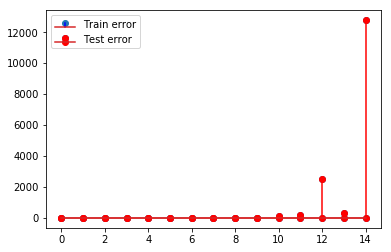

In [8]:
n_points = 35
n_test = 200
n_grid = 200
frec = 3
std_n = 0.7
max_degree = 15

colors = 'brgcmyk'

#Location of the training points
X_tr = (3 * np.random.random((n_points,1)) - 0.5)
#Labels are obtained from a sinusoidal function, and contaminated by noise
S_tr = np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
#Test points to validate the generalization of the solution
X_tst = (3 * np.random.random((n_test,1)) - 0.5)
S_tst = np.cos(frec*X_tst) + std_n * np.random.randn(n_test,1)

#Equally spaced points in the X-axis
X_grid = np.linspace(np.min(X_tr),np.max(X_tr),n_grid)

#We start by building the Z matrix
def extend_matrix(X,max_degree):
    Z = []
    X = X.reshape((X.shape[0],1))
    for el in X.tolist():
        Z.append([el[0]**k for k in range(max_degree+1)])
    return np.matrix(Z)
    
Z = extend_matrix(X_tr,max_degree)
Z_grid = extend_matrix(X_grid,max_degree)
Z_test = extend_matrix(X_tst,max_degree)
#Variables to store the train and test errors
tr_error = []
tst_error = []

for k in range(max_degree):
    Z_iter = Z[:,:k+1]
    #Least square solution
    #w_LS = (np.linalg.inv(Z_iter.T.dot(Z_iter))).dot(Z_iter.T).dot(S_tr)

    # Least squares solution, with leass numerical errors
    w_LS, resid, rank, s = np.linalg.lstsq(Z_iter, S_tr)

    #estimates at traint and test points
    f_tr = Z_iter.dot(w_LS)
    f_tst = Z_test[:,:k+1].dot(w_LS)
    tr_error.append(np.array((S_tr-f_tr).T.dot(S_tr-f_tr)/len(S_tr))[0,0])
    tst_error.append(np.array((S_tst-f_tst).T.dot(S_tst-f_tst)/len(S_tst))[0,0])
    
plt.stem(range(max_degree),tr_error,'b-',label='Train error')
plt.stem(range(max_degree),tst_error,'r-o',label='Test error')
plt.legend(loc='best')
plt.show()

#### 2.4.1 Limitations of the LS approach. The need for assumptions

Another way to visualize the effect of overfiting is to analyze the effect of variations o a single sample. Consider a training dataset consisting of 15 points which are given, and depict the regression curves that would be obtained if adding an additional point at a fixed location, depending on the target value of that point:

(You can run this code fragment several times, to check also the changes in the regression curves between executions, and depending also on the location of the training points)

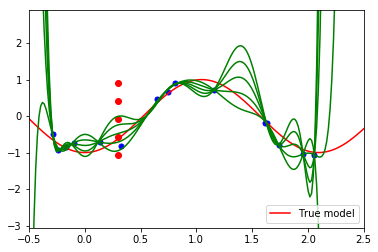

In [9]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
n_val_16 = 5
degree = 12

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-.5,2.5,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

X_16 = .3 * np.ones((n_val_16,))
S_16 = np.linspace(np.min(S_tr),np.max(S_tr),n_val_16)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)
ax.plot(X_16,S_16,'ro',markersize=6)
ax.plot(X_grid,S_grid,'r-',label='True model')

for el in zip(X_16,S_16):
    #Add point to the training set
    X_tr_iter = np.append(X_tr,el[0])
    S_tr_iter = np.append(S_tr,el[1])
    
    #Obtain LS regression coefficients and evaluate it at X_grid
    w_LS = np.polyfit(X_tr_iter, S_tr_iter, degree)
    S_grid_iter = np.polyval(w_LS,X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

ax.set_xlim(-.5,2.5)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)
ax.legend(loc='best')
plt.show()

### Exercise

Analyze the performance of LS regression on the `Advertising` dataset. You can analyze:

  - The performance of linear regression when using just one variable, or using all of them together
  - The performance of different non-linear methods (e.g., polynomial or logarithmic transformations)
  - Model selection using CV strategies